In [1]:
# !pip install bionemo bionemo-controlled-generation biopython python-dotenv pandas numpy matplotlib loguru py3dmol
!pip install rdkit python-dotenv pandas numpy matplotlib loguru py3dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.0 MB/s eta 0:00:00


# Step 2. Controlled generation of novel molecules using MolMIM

This notebook is adapted from the [custom oracles notebook](https://github.com/NVIDIA/BioNeMo/blob/main/examples/service/notebooks/cma_custom_oracles.ipynb) from NVIDIA bionemo python client repository.

This tutorial demonstrates how to use the molmim_cma package to optimize exploration of the [MolMIM](https://arxiv.org/abs/2208.09016) model's latent space to generate molecules
with properties of interest. To do this, we use the [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES) genetic optimization algorithm. The basic steps of optimization are:

1. Decode latent representations into smiles strings
2. Score generated smiles strings based on the desired oracle function
3. Update the CMA-ES algorithm with the smiles/score pairing
4. Ask the CMA-ES algorithm for a new set of latent space representations to sample.

In [2]:
# load environment variables from .env file, which contains API key
import pickle
from typing import List
import numpy as np
# from guided_molecule_gen.optimizer import (
#     MoleculeGenerationOptimizer,
#     SingleMoleculeCMAOptimizer,
# )
# from guided_molecule_gen.oracles import qed, tanimoto_similarity
from rdkit.Chem.QED import qed as rdkit_qed
from rdkit import Chem
# from bionemo.api import BionemoClient as BaseClient
# from guided_molecule_gen.inference_client import BioNemoServiceClient
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
# from scripts.utils import *
# from dotenv import load_dotenv
# load_dotenv()
from rdkit.Chem.QED import qed
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs import TanimotoSimilarity
import ast
from google.colab import userdata
import os, shutil, requests
import pandas as pd

Then we can import and install library dependencies.

Now, let's set  up our molecule, which the PDB ID SZD (a malic enzyme inhibitor)

We'll run three replicates of optimization simulataneously - you could also seed different molecules here.

## 2.3 Set up the starting molecule

Original QED: 0.49932687830292277


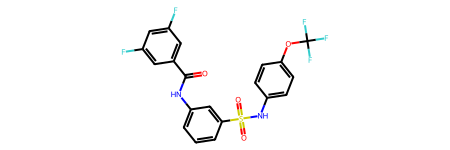

In [3]:
smis = "O=C(Nc1cccc(S(=O)(=O)Nc2ccc(OC(F)(F)F)cc2)c1)c1cc(F)cc(F)c1"

mol = Chem.MolFromSmiles(smis)
qed_score = rdkit_qed(mol)
print(f"Original QED: {qed_score}")
mol

## Guided Molecular Generation with CMA-ES

In contrast to the random sampling of the latent space described (which is available when you self-host MolMIM NIM, see [doc](https://docs.nvidia.com/nim/bionemo/molmim/latest/endpoints.html#)), we can use a black box optimizer, called CMA-ES, to perform guided optimization of the a molecule's property through sampling of the latent space. In the blocks below, we use CMA-ES to optimize the QED score of the generated molecules while preseving a level of similary to the seed molecule, PDB ID SZD.

This first block initializes variables to store the results of the script and sets up the parameters for the experiment. It defines three lists to store the counts of valid SMILES strings, average Tanimoto similarities, and average QED scores. It also creates an empty dictionary to store the results and a list of minimum similarities to be used in the experiment, ranging from 0.1 to 0.7 with 3 evenly spaced values.

In [4]:
# Initialize lists to store the results
# valid_smiles_counts = []
# avg_tanimoto_similarities = []
# avg_qed_scores = []

# Create a dictionary to store the results
results = {}

# Create a list of minimum similarities
num_min_sims = 3
min_sims = np.linspace(0.1, 0.7, num_min_sims)

The following block is the main loop of the script, where it iterates over each minimum similarity value in the `min_sims` list. For each minimum similarity, it generates molecules using the CMA-ES algorithm, calculates the Tanimoto similarity and QED score for each SMILES string, and stores the results. The results are stored in a dictionary called `results`, where the keys are the minimum similarity values and the values are dictionaries containing the number of valid SMILES strings, average Tanimoto similarity, and average QED score. After the loop, the results are converted into a Pandas dataframe for further analysis.

In [5]:
def tanimoto_similarity(smiles, reference: str):
    # Get fingerprint params
    fingerprint_radius_param = 2
    fingerprint_nbits = 2048

    # Handle the reference molecule
    reference_mol = Chem.MolFromSmiles(reference)
    reference_fingerprint = GetMorganFingerprintAsBitVect(
        reference_mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits
    )

    # Validate the other molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    fingerprint = GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits)

    # Calculate and return the Tanimoto similarity
    return TanimotoSimilarity(fingerprint, reference_fingerprint)

In [6]:
# import ast
# from google.colab import userdata

API_KEY = userdata.get('API_KEY')
# print(API_KEY)

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Accept": "application/json",
}

invoke_url = "https://health.api.nvidia.com/v1/biology/nvidia/molmim/generate"

session = requests.Session()

# Loop through each minimum similarity value
for min_sim in min_sims:
    # Create a dictionary to store the results for this min_sim
    min_sim_results = {'smiles': [], 'num_smiles': [], 'tanimoto_similarity': [], 'qed_score': []}

    # Create the request payload
    payload = {
      "smi": smis,
      "algorithm": "CMA-ES",
      "num_molecules": 10,
      "property_name": "QED",
      "minimize": False,
      "min_similarity": min_sim,
      "particles": 20,
      "iterations": 2,
    }

    # Send the request and get the response
    response = session.post(invoke_url, headers=headers, json=payload)
    response.raise_for_status()
    response_json = response.json()
    print(f"*************** min_sim: {min_sim} ********************")
    print(f"response_json: \n"
          f"{response_json}")

    # Extract the generated SMILES
    gen_smiles_list = [i['sample'] for i in ast.literal_eval(response_json['molecules'])]
    print(f"gen_smiles_list: \n"
          f"{gen_smiles_list}")
    # get the molecule objects out of valid SMILES
    valid_mol_list = [mol for smiles in gen_smiles_list if (mol := Chem.MolFromSmiles(smiles))]
    # convert to canonical SMILES & deduplicate
    canonical_smiles = set()
    for mol in valid_mol_list:
        canonical_smi = Chem.MolToSmiles(mol, canonical=True)
        canonical_smiles.add(canonical_smi)
    canonical_smiles_list = list(canonical_smiles)
    print(f"canonical_smiles_list: \n"
          f"{canonical_smiles_list}")

    # Calculate Tanimoto similarity and QED score for each valid SMILES
    for smiles in canonical_smiles_list:
        tanimoto = tanimoto_similarity(smiles, smis)
        mol = Chem.MolFromSmiles(smiles)
        qed_score = qed(mol)
        min_sim_results['tanimoto_similarity'].append(tanimoto)
        min_sim_results['qed_score'].append(qed_score)

    # Update min_sim_results - get the average of Tanimoto and QED scores, store generated SMILES
    min_sim_results['tanimoto_similarity'] = np.mean(min_sim_results['tanimoto_similarity'])
    min_sim_results['qed_score'] = np.mean(min_sim_results['qed_score'])
    min_sim_results['num_smiles'] = len(canonical_smiles_list)
    min_sim_results['smiles'] = canonical_smiles_list

    # Store the results for this min_sim
    results[min_sim] = min_sim_results

*************** min_sim: 0.1 ********************
response_json: 
{'molecules': '[{"sample": "O=C(Nc1ccc(OC(F)F)cc1)N1CCN(C(=O)c2ccc(F)cc2)CC1", "score": 0.8660455203846833}, {"sample": "COc1cc(F)ccc1NS(=O)(=O)c1ccc(F)c(C(F)(F)F)c1", "score": 0.8368577058455364}, {"sample": "O=C(NS(=O)(=O)c1cccc(OC(F)(F)F)c1)c1ccc(F)c(Cl)c1", "score": 0.8014742295187183}, {"sample": "O=C(NCc1ccc(NS(=O)(=O)c2ccc(F)cc2)cc1)[C@H]1C[C@@H]1C(F)(F)F", "score": 0.7087866838852815}, {"sample": "O=C(CNS(=O)(=O)c1ccc(F)c(F)c1)Nc1cn(CC(F)(F)F)nn1", "score": 0.70636069179847}, {"sample": "COc1cc(Nc2ccc(S(=O)(=O)Nc3ccc(F)c(F)c3)cc2)ccc1F", "score": 0.622794650115424}, {"sample": "O=C(NCc1cccc(C(F)(F)F)c1)C(=O)Nc1cccc(OC(F)F)c1", "score": 0.6081020886527891}, {"sample": "COc1ccc(NC(=O)c2ccc(S(=O)(=O)Nc3ccc(F)c(F)c3)cc2)cc1F", "score": 0.6077082178367843}, {"sample": "COc1cc(NC(=O)c2cccc(S(=O)(=O)c3ccc(F)c(F)c3)c2)cc(OC)c1", "score": 0.5930245819107047}, {"sample": "COc1ccc(NC(=O)COC(=O)c2cccc(NC(=O)c3ccc(F)cc3)c2)cc

[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerator
[22:07:46] DEPRECATION WARNING: please use MorganGenerat

*************** min_sim: 0.4 ********************
response_json: 
{'molecules': '[{"sample": "O=C(O)c1cc(NS(=O)(=O)c2cccc(C(F)(F)F)c2)ccc1F", "score": 0.8164024525328468}, {"sample": "O=S(=O)(Nc1cccc(OC(F)(F)F)c1)c1cc(F)cc(C(F)(F)F)c1", "score": 0.7629024481600742}, {"sample": "C[C@@H]1CCCN(S(=O)(=O)c2cccc(C(=O)Nc3cc(F)cc(OC(F)(F)F)c3)c2)C1", "score": 0.6716438689801733}, {"sample": "Nc1cc(NS(=O)(=O)c2cccc(F)c2)cc(C(F)(F)F)c1", "score": 0.6685655205025507}, {"sample": "O=C(Nc1ccc(Oc2cc(F)cc(F)c2)cc1)c1ccc(F)c(F)c1", "score": 0.6416467148399471}, {"sample": "O=C(Nc1cccc(OC(F)(F)F)c1)c1ccc2c(c1)S(=O)(=O)N(c1ccccc1)C2=O", "score": 0.6279240959795985}, {"sample": "O=C(Nc1ccc(O)c(C(F)(F)F)c1)c1cc(F)cc(Br)c1", "score": 0.594591571751476}, {"sample": "O=S(=O)(Nc1ccc(Oc2ccc(F)cc2)cc1)c1cccc(C(F)(F)F)c1", "score": 0.5692648835391796}, {"sample": "COc1ccc(NC(=O)c2ccc(C(F)(F)F)cc2)cc1S(=O)(=O)Nc1ccccc1", "score": 0.5668714494662869}, {"sample": "O=C(Nc1ccc2c(c1)OCCO2)c1ccc(NS(=O)(=O)c2cccc(C(F)(F

[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerator
[22:07:48] DEPRECATION WARNING: please use MorganGenerat

*************** min_sim: 0.7 ********************
response_json: 
{'molecules': '[{"sample": "O=S(=O)(Cc1ccc(F)cc1)Nc1ccc(OC(F)(F)F)cc1F", "score": 0.8181166328722356}, {"sample": "O=C(Nc1ccc(S(=O)(=O)Nc2ccccc2)cc1)c1ccc(F)c(F)c1", "score": 0.6932926199936232}, {"sample": "O=C(Nc1cccc(C(=O)Nc2ccc(OC(F)(F)F)cc2)c1)c1ccc(F)cc1", "score": 0.5579449657255281}, {"sample": "O=C(Nc1ccc(OC(F)(F)F)cc1)c1cccc(Nc2cccc(F)c2)c1", "score": 0.5480410835043059}, {"sample": "O=C(Nc1cccc(S(=O)(=O)Nc2ccc(OC(F)(F)F)cc2)c1)c1cccc(F)c1", "score": 0.525478599674303}, {"sample": "O=C(Nc1cccc(S(=O)(=O)Nc2ccc(OC(F)(F)F)cc2)c1)c1cccc(F)c1", "score": 0.525478599674303}, {"sample": "O=C(Nc1cccc(S(=O)(=O)Nc2ccc(OC(F)(F)F)cc2)c1)c1cccc(F)c1", "score": 0.525478599674303}, {"sample": "O=C(Nc1cccc(S(=O)(=O)Nc2cccc(OC(F)(F)F)c2)c1)c1cccc(F)c1", "score": 0.525478599674303}, {"sample": "O=C(Nc1ccc(F)c(F)c1)c1cccc(NS(=O)(=O)c2ccc(OC(F)(F)F)cc2)c1", "score": 0.4993268783029225}, {"sample": "O=C(Nc1cccc(S(=O)(=O)Nc2cc(F)cc(O

[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator
[22:07:49] DEPRECATION WARNING: please use MorganGenerator


In [7]:
# Create a Pandas dataframe from the results
# df = pd.DataFrame(results).T.reset_index()
# Specify the keys you want to include
keys_to_include = ['num_smiles', 'tanimoto_similarity', 'qed_score']
# Create the DataFrame, selecting only the specified keys from each inner dictionary
df = pd.DataFrame({k: {key: val[key] for key in keys_to_include} for k, val in results.items()}).T.reset_index()
print(df)

   index  num_smiles  tanimoto_similarity  qed_score
0    0.1        10.0             0.317729   0.691499
1    0.4        10.0             0.420298   0.648199
2    0.7         8.0             0.610464   0.583376


The following block creates three plots to visualize the results of the script. The first plot shows the number of valid SMILES strings generated at each minimum similarity threshold. The second plot shows the average Tanimoto similarity of the generated molecules at each minimum similarity threshold. The third plot shows the average QED score of the generated molecules at each minimum similarity threshold. The plots are arranged in a single figure with three subplots, and the figure is displayed using the `plt.show()` function.

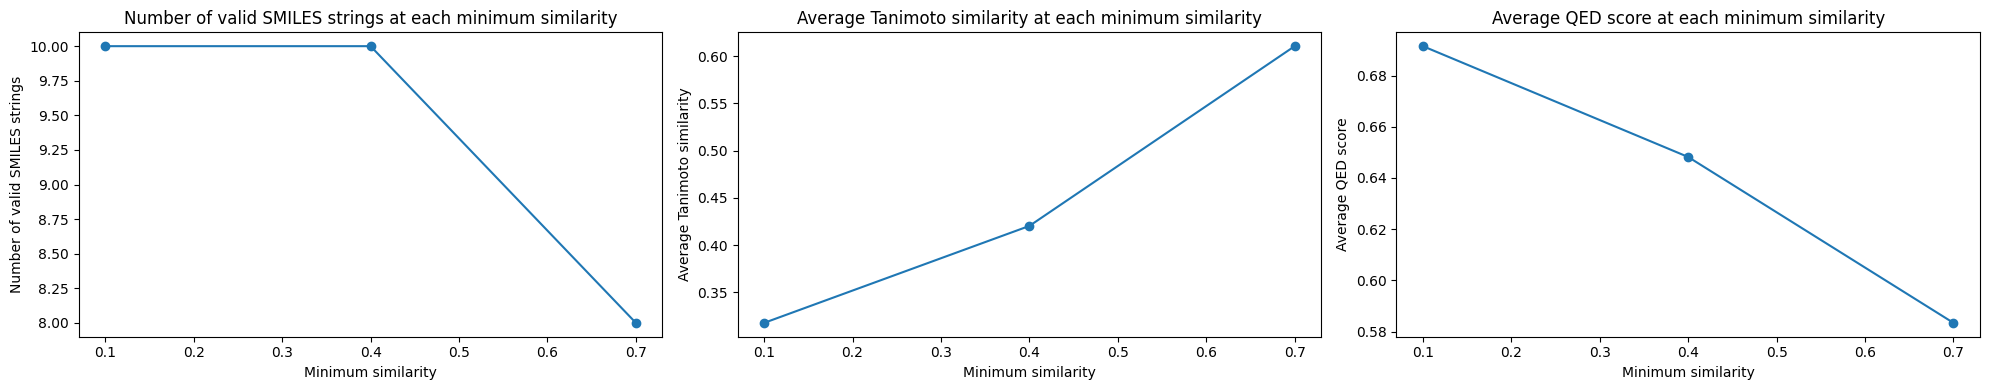

In [8]:
# Create the plots
plt.figure(figsize=(20, 4))

# Plot the number of valid SMILES strings at each min_sim
plt.subplot(1, 3, 1)
plt.plot(df['index'], df['num_smiles'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Number of valid SMILES strings')
plt.title('Number of valid SMILES strings at each minimum similarity')

# Plot the average Tanimoto similarity at each radius
plt.subplot(1, 3, 2)
plt.plot(df['index'], df['tanimoto_similarity'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Average Tanimoto similarity')
plt.title('Average Tanimoto similarity at each minimum similarity')

# Plot the average QED score at each radius
plt.subplot(1, 3, 3)
plt.plot(df['index'], df['qed_score'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Average QED score')
plt.title('Average QED score at each minimum similarity')

plt.tight_layout()
plt.show()

<!-- ## 2.7 [Optional] Save the generated molecules -->

In [9]:
# def prepare_output_directory(output):
#     """
#     Prepare the output directory
#     output: str, the output directory
#     return: None
#     """
#     # overwrite the output directory
#     # delete the output directory if it exists
#     if os.path.exists(output):
#         shutil.rmtree(output)
#     os.makedirs(output)

In [10]:
# # overwrite the output directory
# output_dir = "/content/output/molmim_result"
# prepare_output_directory(output_dir)

# output_fp = os.path.join(output_dir, "generated_molecules.pkl")
# with open(output_fp, "wb") as f:
#     pickle.dump(results, f)

## 2.8 Preprocess the generated molecules for diffdock

In [11]:
# choose the first N molecules from the individual runs to use for docking,
# for demo purpose we will set it to 3 for now.
N_molecules_for_docking = 3

# for each sublists, choose the first N molecules
molecules = [
    molecule
    for min_sim_key, min_sim_val in results.items()
    for molecule in min_sim_val['smiles'][:N_molecules_for_docking]
]
print(molecules)

['COc1ccc(NC(=O)COC(=O)c2cccc(NC(=O)c3ccc(F)cc3)c2)cc1', 'COc1cc(F)ccc1NS(=O)(=O)c1ccc(F)c(C(F)(F)F)c1', 'O=C(CNS(=O)(=O)c1ccc(F)c(F)c1)Nc1cn(CC(F)(F)F)nn1', 'C[C@@H]1CCCN(S(=O)(=O)c2cccc(C(=O)Nc3cc(F)cc(OC(F)(F)F)c3)c2)C1', 'O=S(=O)(Nc1cccc(OC(F)(F)F)c1)c1cc(F)cc(C(F)(F)F)c1', 'COc1ccc(NC(=O)c2ccc(C(F)(F)F)cc2)cc1S(=O)(=O)Nc1ccccc1', 'O=C(Nc1cccc(S(=O)(=O)Nc2ccc(OC(F)(F)F)cc2)c1)c1cccc(F)c1', 'O=C(Nc1cccc(S(=O)(=O)Nc2cccc(OC(F)(F)F)c2)c1)c1cccc(F)c1', 'O=C(Nc1ccc(S(=O)(=O)Nc2ccccc2)cc1)c1ccc(F)c(F)c1']


In [12]:
# # convert to SDF
# output_files = []
# for i, smiles in enumerate(valid_canonical_smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     mol = Chem.AddHs(mol)
#     AllChem.EmbedMolecule(mol)
#     AllChem.UFFOptimizeMolecule(mol)

#     # save the clean file to molmim_result

#     w = Chem.SDWriter(f"{output_dir}/molecule_{i}.sdf")
#     w.write(mol)
#     w.close()
#     print(f"Converted SMILES to SDF: {smiles}")
#     output_files.append(f"{output_dir}/molecule_{i}.sdf")

# return output_files

In [13]:
def prepare_output_directory(output):
    """
    Prepare the output directory
    output: str, the output directory
    return: None
    """
    # overwrite the output directory
    # delete the output directory if it exists
    if os.path.exists(output):
        shutil.rmtree(output)
    os.makedirs(output)

In [14]:
# converts SMILES to SDF (generate 1 conformer for each smile)
# overwrite output dir
output_dir = "/content/output/molmim_result"
output_dir_clean = os.path.join(output_dir, "clean_mols")
prepare_output_directory(output_dir_clean)

# convert to SDF
output_sdf_files = []
for i, smiles in enumerate(molecules):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    # save the clean file
    path = f"{output_dir_clean}/molecule_{i}.sdf"
    w = Chem.SDWriter(path)
    w.write(mol)
    w.close()
    print(f"Converted SMILES to SDF: {smiles}")
    output_sdf_files.append(path)

# here are the paths to the generated molecules in SDF format, which can be used for docking
print(output_sdf_files)

Converted SMILES to SDF: COc1ccc(NC(=O)COC(=O)c2cccc(NC(=O)c3ccc(F)cc3)c2)cc1
Converted SMILES to SDF: COc1cc(F)ccc1NS(=O)(=O)c1ccc(F)c(C(F)(F)F)c1
Converted SMILES to SDF: O=C(CNS(=O)(=O)c1ccc(F)c(F)c1)Nc1cn(CC(F)(F)F)nn1
Converted SMILES to SDF: C[C@@H]1CCCN(S(=O)(=O)c2cccc(C(=O)Nc3cc(F)cc(OC(F)(F)F)c3)c2)C1
Converted SMILES to SDF: O=S(=O)(Nc1cccc(OC(F)(F)F)c1)c1cc(F)cc(C(F)(F)F)c1
Converted SMILES to SDF: COc1ccc(NC(=O)c2ccc(C(F)(F)F)cc2)cc1S(=O)(=O)Nc1ccccc1
Converted SMILES to SDF: O=C(Nc1cccc(S(=O)(=O)Nc2ccc(OC(F)(F)F)cc2)c1)c1cccc(F)c1
Converted SMILES to SDF: O=C(Nc1cccc(S(=O)(=O)Nc2cccc(OC(F)(F)F)c2)c1)c1cccc(F)c1
Converted SMILES to SDF: O=C(Nc1ccc(S(=O)(=O)Nc2ccccc2)cc1)c1ccc(F)c(F)c1
['/content/output/molmim_result/clean_mols/molecule_0.sdf', '/content/output/molmim_result/clean_mols/molecule_1.sdf', '/content/output/molmim_result/clean_mols/molecule_2.sdf', '/content/output/molmim_result/clean_mols/molecule_3.sdf', '/content/output/molmim_result/clean_mols/molecule_4.sdf'

# **Download SDF files**

In [15]:
output_dir_clean

'/content/output/molmim_result/clean_mols'

In [20]:
# Step 1: Zip the directory
zip_filename = "clean_mols.zip"
!cd {output_dir_clean} && zip -r {zip_filename} .

  adding: molecule_6.sdf (deflated 78%)
  adding: molecule_0.sdf (deflated 78%)
  adding: .ipynb_checkpoints/ (stored 0%)
  adding: molecule_2.sdf (deflated 78%)
  adding: molecule_4.sdf (deflated 77%)
  adding: molecule_1.sdf (deflated 78%)
  adding: molecule_3.sdf (deflated 78%)
  adding: molecule_5.sdf (deflated 78%)
  adding: molecule_7.sdf (deflated 78%)
  adding: molecule_8.sdf (deflated 78%)


In [21]:
# Step 2: Download the zipped file
from google.colab import files
files.download(os.path.join(output_dir_clean, zip_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>